# B-SOSE preliminary

This notebook contains some early drafts and examples of interacting with a future BSOSE index on Argovis. None of the features or schema below are in production, and all may change before release.

In [113]:
import requests, copy, os, sys, pandas, xarray
sys.path.append(os.path.abspath(os.pardir))
import helpers
from argovisHelpers import helpers as avh
import matplotlib.pyplot as plt

API_ROOT="https://argovis-apix-atoc-argovis-dev.apps.containers02.colorado.edu"

Start by grabbing some BSOSE data. It is timeseries formatted, each data document corresponding to a specific lat / long / depth triple, with metadata unique to this coordinate included on the data doc.

In [163]:
qs = {
    "box": '[[-1,-31],[0,-29]]',
    "data": 'all'
}

bsose = requests.get(API_ROOT+"/timeseries/bsose", params=qs).json()

In [164]:
bsose[0]

{'_id': '-0.750_-30.305_-2.100',
 'metadata': ['-0.750_-30.305'],
 'basin': 1,
 'geolocation': {'type': 'Point', 'coordinates': [-0.75, -30.305381774902344]},
 'level': 2.0999999046325684,
 'data': [[0.0005019201198592782,
   0.0004640000406652689,
   0.0004143622354604304,
   0.0003750708419829607,
   0.000343850813806057,
   0.00029932387406006455,
   0.0002772728039417416,
   0.0002657548466231674,
   0.00026025305851362646,
   0.0002480939729139209,
   0.00024063057207968086,
   0.00022660924878437072,
   0.00021926467888988554,
   0.0002159775176551193,
   0.00020750398107338697,
   0.00021795362408738583,
   0.00020672444952651858,
   0.00020744960056617856,
   0.00024373515043407679,
   0.00024715971085242927,
   0.00026601890567690134,
   0.0002873951743822545,
   0.0003055960114579648,
   0.00029570164042524993,
   0.0002847060386557132,
   0.0003410681674722582,
   0.0003219551872462034,
   0.0003092304104939103,
   0.0003303837147541344,
   0.00036847489536739886,
   0.00044

We can grab the corresponding metadata, one metadata doc for each lat/long point:

In [165]:
qs_meta = copy.deepcopy(qs)
qs_meta['batchmeta'] = True
bsose_meta = requests.get(API_ROOT+"/timeseries/bsose", params=qs_meta).json()
bsose_meta[0]

{'_id': '-0.083_-29.715',
 'latitude': -29.715316772460938,
 'longitude': -0.08331298828125,
 'data_type': 'BSOSE-profile',
 'date_updated_argovis': '2024-03-21T19:41:51.660Z',
 'timeseries': ['2012-12-31T00:00:00.000Z',
  '2013-01-05T00:00:00.000Z',
  '2013-01-10T00:00:00.000Z',
  '2013-01-15T00:00:00.000Z',
  '2013-01-20T00:00:00.000Z',
  '2013-01-25T00:00:00.000Z',
  '2013-01-30T00:00:00.000Z',
  '2013-02-04T00:00:00.000Z',
  '2013-02-09T00:00:00.000Z',
  '2013-02-14T00:00:00.000Z',
  '2013-02-19T00:00:00.000Z',
  '2013-02-24T00:00:00.000Z',
  '2013-03-01T00:00:00.000Z',
  '2013-03-06T00:00:00.000Z',
  '2013-03-11T00:00:00.000Z',
  '2013-03-16T00:00:00.000Z',
  '2013-03-21T00:00:00.000Z',
  '2013-03-26T00:00:00.000Z',
  '2013-03-31T00:00:00.000Z',
  '2013-04-05T00:00:00.000Z',
  '2013-04-10T00:00:00.000Z',
  '2013-04-15T00:00:00.000Z',
  '2013-04-20T00:00:00.000Z',
  '2013-04-25T00:00:00.000Z',
  '2013-04-30T00:00:00.000Z',
  '2013-05-05T00:00:00.000Z',
  '2013-05-10T00:00:00.000Z',

From here it is a trivial matter to turn Argovis data into pandas data frames and xarray data sets, and leverage all the built in slicing and plotting those tools offer:

In [166]:
df = helpers.level_df(bsose, 
                      ['TRAC04', 'SALT', 'longitude', 'latitude', 'level'], 
                      timesteps=bsose_meta[0]['timeseries'], 
                      index=["latitude","longitude","timestamp","level"]
                     )
ds = df.to_xarray()

In [167]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 5, timestamp: 658, level: 50)
Coordinates:
  * latitude   (latitude) float64 -30.31 -30.16 -30.02 -29.87 -29.72
  * longitude  (longitude) float64 -0.75 -0.5833 -0.4167 -0.25 -0.08331
  * timestamp  (timestamp) datetime64[ns] 2012-12-31 2013-01-05 ... 2021-12-29
  * level      (level) float64 2.1 6.7 12.15 18.55 ... 4.2e+03 4.6e+03 5e+03
Data variables:
    TRAC04     (latitude, longitude, timestamp, level) float64 0.0005019 ... nan
    SALT       (latitude, longitude, timestamp, level) float64 35.91 ... nan

Let's start by plotting a simple map of both our variables for a single timestamp and level:

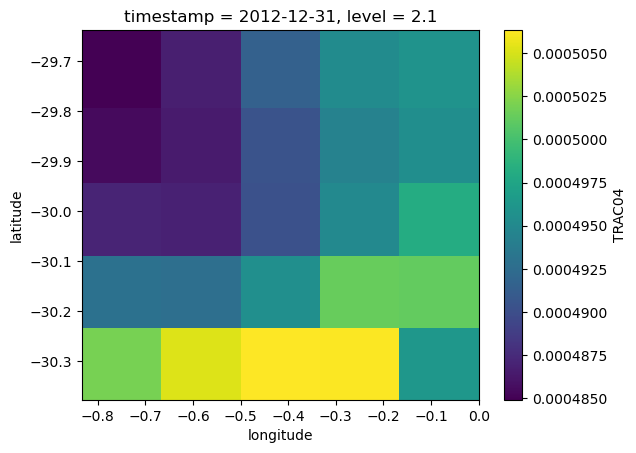

In [168]:
simplemap = ds.loc[{"timestamp":avh.parsetime('2012-12-31T00:00:00.000Z'), "level":ds['level'][0]}]
simplemap['TRAC04'].plot()

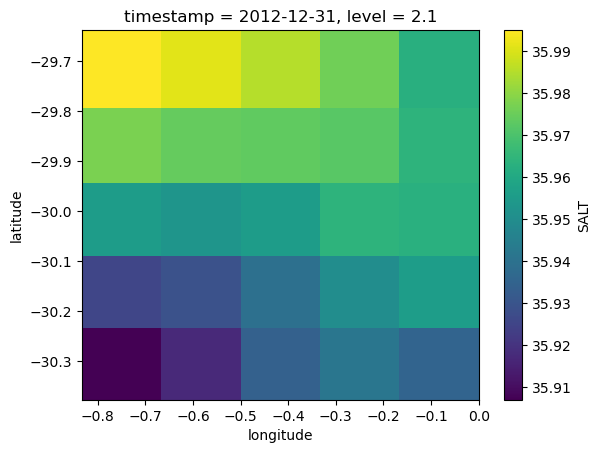

In [169]:
simplemap['SALT'].plot()

We can also do timeseries for a specific geospatial point, to reveal seasonal cycles:

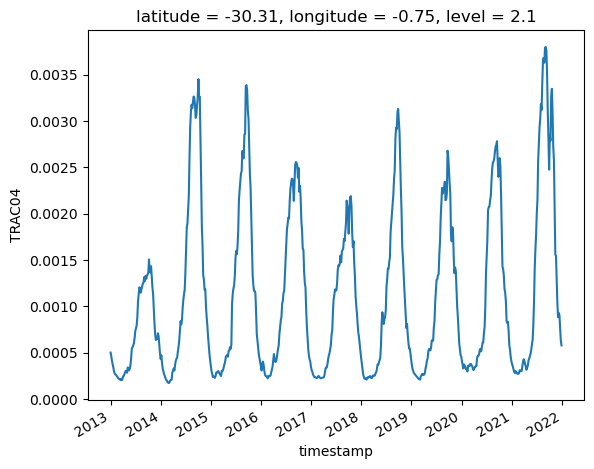

In [170]:
simple_ts = ds.loc[{"longitude": ds['longitude'][0], "latitude": ds['latitude'][0], "level": ds['level'][0]}]
simple_ts['TRAC04'].plot()

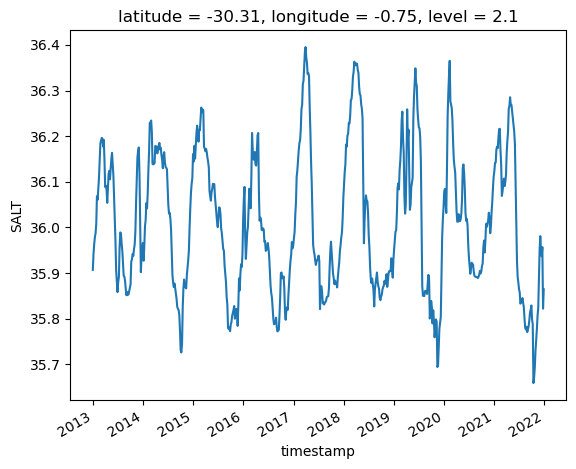

In [171]:
simple_ts['SALT'].plot()

Profiles at a given lat / long / timestep triple are constructed similarly:

In [172]:
simple_profile = ds.loc[{"longitude": ds['longitude'][0], "latitude": ds['latitude'][0], "timestamp": ds['timestamp'][0]}]

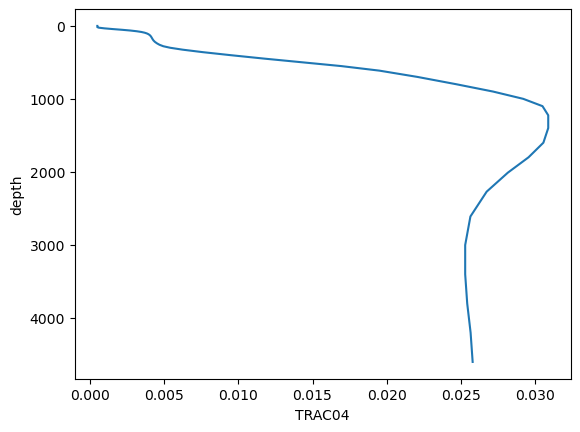

In [173]:
var = 'TRAC04'
plt.plot(simple_profile[var], simple_profile['level'])
plt.gca().invert_yaxis()
plt.xlabel(var)
plt.ylabel('depth')
plt.show()

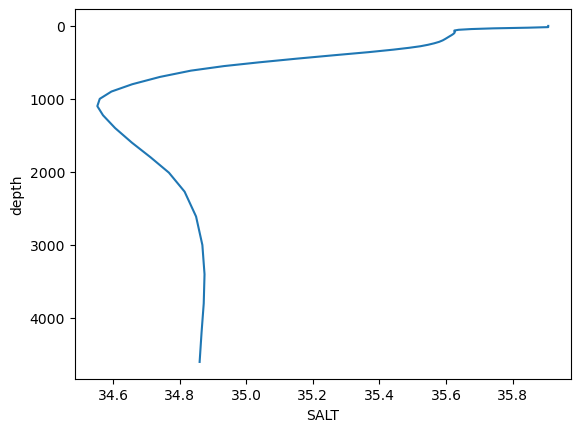

In [174]:
var = 'SALT'
plt.plot(simple_profile[var], simple_profile['level'])
plt.gca().invert_yaxis()
plt.xlabel(var)
plt.ylabel('depth')
plt.show()

BSOSE reports model cell areas at each latitude / longitude point. We can use these cell areas to construct area weighted means, including meridional and zonal means:

In [175]:
weight_table = [{'weight': x['cell_area'], 'longitude': x['longitude'], 'latitude': x['latitude']} for x in bsose_meta]
weight_df = pandas.DataFrame(weight_table)
weight_ds = xarray.Dataset.from_dataframe(weight_df.set_index(["latitude", "longitude"]))
weighted_ds = ds.weighted(weight_ds["weight"])

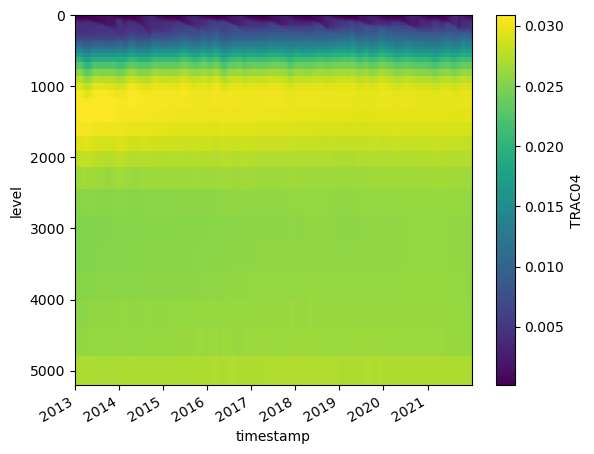

In [176]:
awm = weighted_ds.mean(("longitude", "latitude"))
awm['TRAC04'].plot(y="level",yincrease=False)

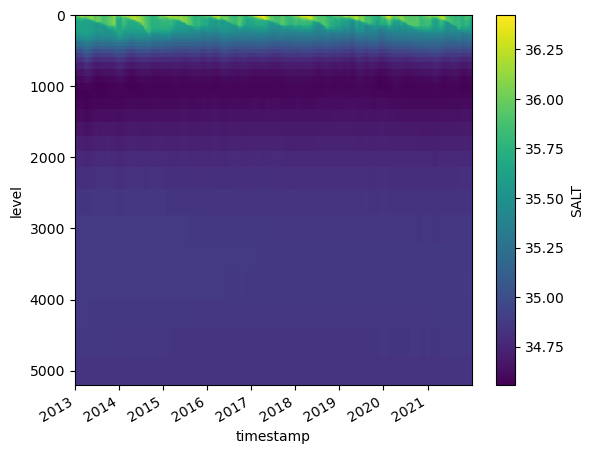

In [177]:
awm['SALT'].plot(y="level",yincrease=False)

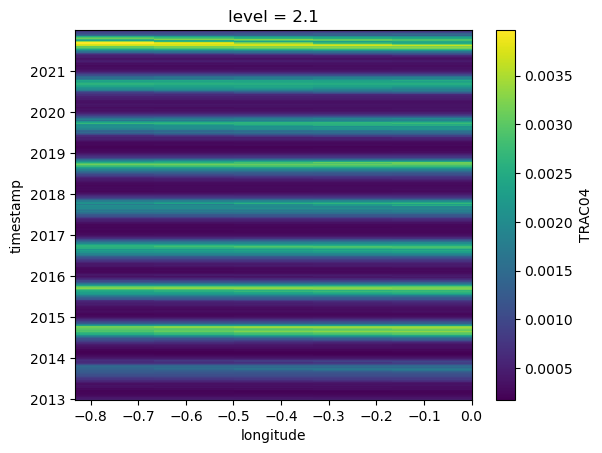

In [178]:
meridional = weighted_ds.mean(("latitude")).loc[{"level":ds['level'][0]}]
meridional['TRAC04'].plot(y='timestamp')

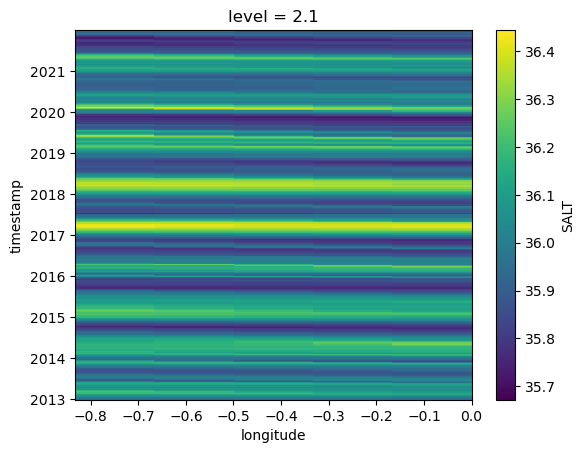

In [179]:
meridional['SALT'].plot(y='timestamp')

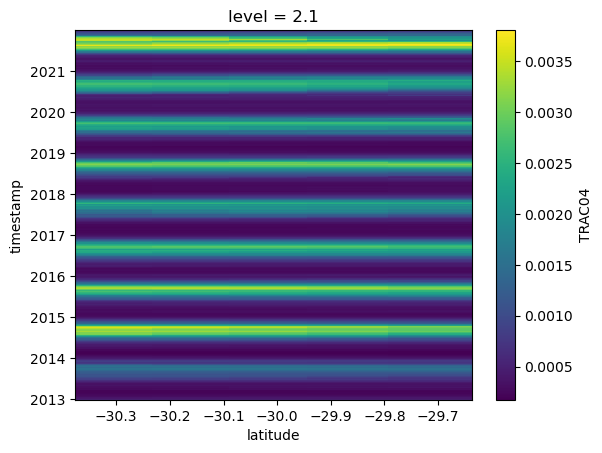

In [180]:
zonal = weighted_ds.mean(("longitude")).loc[{"level":ds['level'][0]}]
zonal['TRAC04'].plot(y='timestamp')

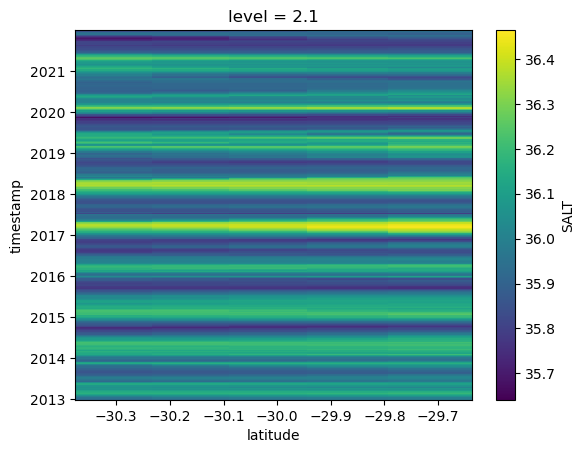

In [181]:
zonal['SALT'].plot(y='timestamp')